In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as random
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy
import pickle

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
from sklearn.model_selection import train_test_split

plt.rcParams.update({'font.size': 18})

In [4]:
def math_fun(x):
    x1=x[:,0]
    x2=x[:,1]
    g=((1.5+x1)**2+4)*(1.5+x2)/20-np.sin(5*(1.5+x1)/2)
    return g

### Prepare the training, testing and OOD data for the ML model
def make_data():
    mean_c1 = (8, 3.5)
    cov_c1 = [[0.4, -0.32], [-0.32, 0.4]]
    c1_sample_no = 500
    x_c1 = np.random.multivariate_normal(mean_c1, cov_c1, (c1_sample_no, 1)).reshape(c1_sample_no, 2)

    mean_c2 = (-2.5, -2.5)
    cov_c2 = [[0.4, -0.32], [-0.32, 0.4]]
    c2_sample_no = 500
    x_c2 = np.random.multivariate_normal(mean_c2, cov_c2, (c2_sample_no, 1)).reshape(c2_sample_no, 2)

    mean_ood = (-10, -7.5)
    cov_ood = [[0.2, -0.16], [-0.16, 0.2]]
    ood_sample_no = 200
    x_ood = np.random.multivariate_normal(mean_ood, cov_ood, (ood_sample_no, 1)).reshape(ood_sample_no, 2) 

    y_c1 = math_fun(x_c1).reshape(-1, 1)
    y_c2 = math_fun(x_c2).reshape(-1, 1)
    y_ood = math_fun(x_ood).reshape(-1, 1)

    ## Create train and test data for each cluster of data
    random_state = 1
    x_c1_train, x_c1_test, y_c1_train, y_c1_test = train_test_split(x_c1, y_c1, test_size=0.2, random_state=random_state)
    x_c2_train, x_c2_test, y_c2_train, y_c2_test = train_test_split(x_c2, y_c2, test_size=0.2, random_state=random_state)

    x_train = np.concatenate((x_c1_train, x_c2_train), axis = 0)
    x_test = np.concatenate((x_c1_test, x_c2_test), axis = 0)
    y_train = np.concatenate((y_c1_train, y_c2_train), axis = 0)
    y_test = np.concatenate((y_c1_test, y_c2_test), axis = 0)

    plt.figure(figsize=(10, 10))
    plt.scatter(x_c1_train[:, 0], x_c1_train[:, 1], color = 'red', marker = '+', label='1st cluster train')
    plt.scatter(x_c1_test[:, 0], x_c1_test[:, 1], color = 'red', marker = 's', label='1st cluster test')

    plt.scatter(x_c2_train[:, 0], x_c2_train[:, 1], color = 'blue', marker = '+', label='2nd cluster train')
    plt.scatter(x_c2_test[:, 0], x_c2_test[:, 1], color = 'blue', marker = 's', label='2nd cluster test')

    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'purple', label = 'OOD samples')

    plt.xlabel('X1', fontsize=22, fontweight='bold')
    plt.ylabel('X2', fontsize=22, fontweight='bold')
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18, fontweight='bold')

    plt.legend(fontsize=20)
    plt.axis('equal')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.tight_layout()
    plt.savefig('train_test_data.pdf')

    n_meshes = 150
    x1, x2 = np.meshgrid(np.linspace(-15, 15, n_meshes), np.linspace(-15, 15, n_meshes))
    x_mesh = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis = 1)
    y_mesh = math_fun(x_mesh).reshape(-1, 1).flatten()

    return x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh

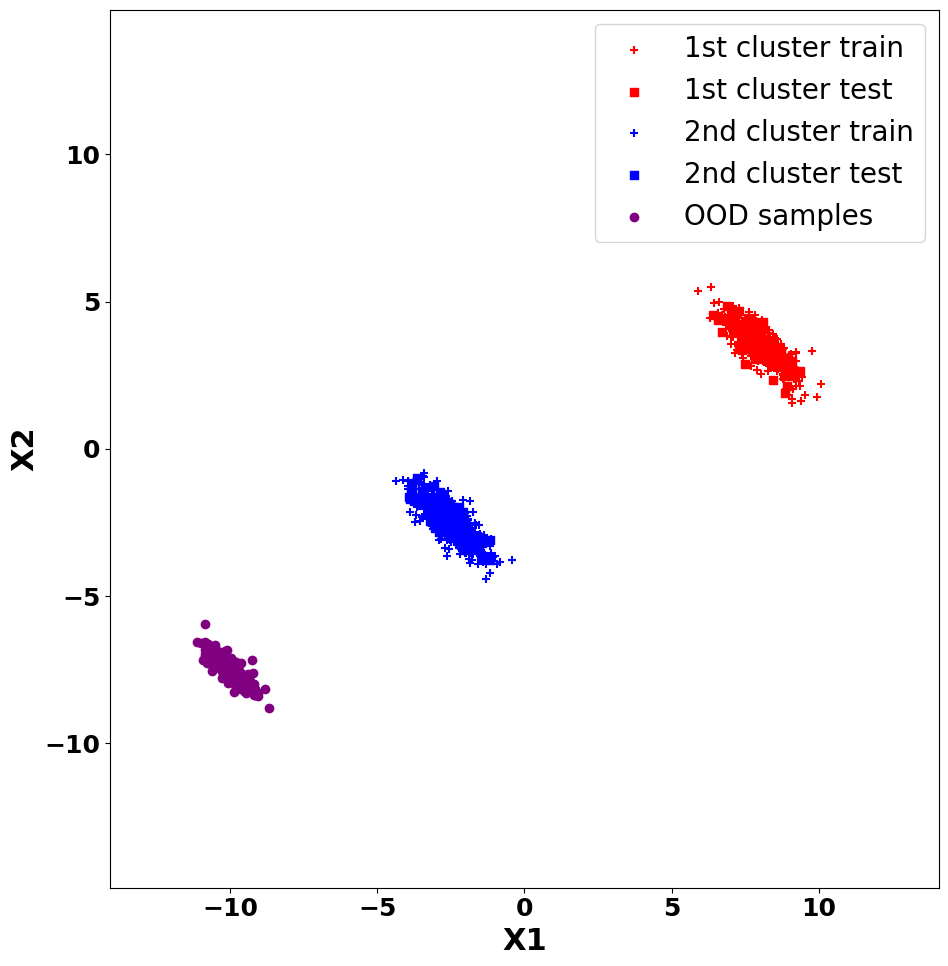

In [5]:
np.random.seed(1)
x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh = make_data()

In [6]:
scalerX, scalerY = MinMaxScaler(), MinMaxScaler()
x_train_norm, y_train_norm = scalerX.fit_transform(x_train), scalerY.fit_transform(y_train)
x_test_norm, y_test_norm = scalerX.transform(x_test), scalerY.transform(y_test)
x_ood_norm, y_ood_norm   = scalerX.transform(x_ood), scalerY.transform(y_ood)
x_mesh_norm = scalerX.transform(x_mesh)
y_mesh_norm = scalerY.transform(y_mesh.reshape(-1, 1))

## Common function definitions

In [7]:
def plot_uncertainty_map(x_train, x_ood, x_mesh, output_std, filename, spectral_normalization = False, contour=False):
    """
    Input
    x_train, x_ood: training and OOD data
    x_mesh: input mesh spanning across the input range
    output_std: 
    """
#     std_scaled = output_std/max(output_std)
    std_scaled = output_std
    plt.figure(figsize=(10, 10))
    plt.rcParams['axes.xmargin'] = 0
    plt.rcParams['axes.ymargin'] = 0
    plt.scatter(x_mesh[:, 0], x_mesh[:, 1], rasterized = True, c = std_scaled, cmap = plt.get_cmap('viridis'))
    
    if spectral_normalization:
        cbar = plt.colorbar(fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=28)
        
    plt.scatter(x_train[:, 0], x_train[:, 1], color = 'magenta', s = 20, alpha = 0.7, label = 'Training')
    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'red', s = 20, alpha = 0.7, label = 'OOD')

    if contour:
        n = np.ceil(np.sqrt(len(std_scaled))).astype(int)
        h = std_scaled.reshape(n, n)
        contours = plt.contour(x_mesh[:, 0].reshape(n, n), x_mesh[:, 1].reshape(n, n), h)
        plt.clabel(contours, inline=True, fontsize=12)

        filename += '_with_contour'

    plt.legend(fontsize=20, loc=4)
    plt.xlabel(r'$x_1$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$x_2$', fontsize=40, fontweight='bold')
    plt.xticks(fontsize=36, fontweight='bold')
    plt.yticks(fontsize=36, fontweight='bold')

    plt.tight_layout()
    ax = plt.gca()
    ax.set_aspect('equal')

# Ensembling of individual models
def get_ensemble(pred_df, UQmodelcode, nmodels_select):
    """
    Input
    pred_df - dataframe with individual model predictions
              Columns named as "NN_mu_#ofmodel" and "NN_sigma_#ofmodel"
    UQmodelcode - 'NN' for neural network ensemble, 'MC' for MC dropout
    nmodels_select - number of individual models to form the ensemble
    """
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = pred_df[mu_cols].mean(axis=1)
    if UQmodelcode=="NN":
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             + np.mean(pred_df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC": # no sigma_cols for individual models
        sigma_eff =  np.sqrt(np.mean(pred_df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    pred_df[UQmodelcode+"_mu_eff"] = mu_eff
    pred_df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return pred_df

def get_rmse(y_true, y_pred):
    """
    Inputs:
    y_true - true values
    y_pred - predicted values
    Outputs:
    root mean squarred error
    """
    return np.sqrt(np.mean((y_true-y_pred)**2))

# UQ model training

Each of the model has the following sequence:
- model functions/class definitions
- a single end-to-end run

## Uncertainty Model: Gaussian Process Regression (GPR)

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

model_GP = GaussianProcessRegressor(kernel=1 * RBF(length_scale=0.001, length_scale_bounds=(1e-3, 1e2)), 
                                    n_restarts_optimizer=10)
model_GP.fit(x_train_norm, y_train_norm)
#  For nu=inf, the kernel becomes equivalent to the RBF kernel and for nu=0.5 to the absolute exponential kernel. 
#  Important intermediate values are nu=1.5 (once differentiable functions) and 
#  nu=2.5 (twice differentiable functions).

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.001),
                         n_restarts_optimizer=10)

train error (RMSE): 284.0198841136143


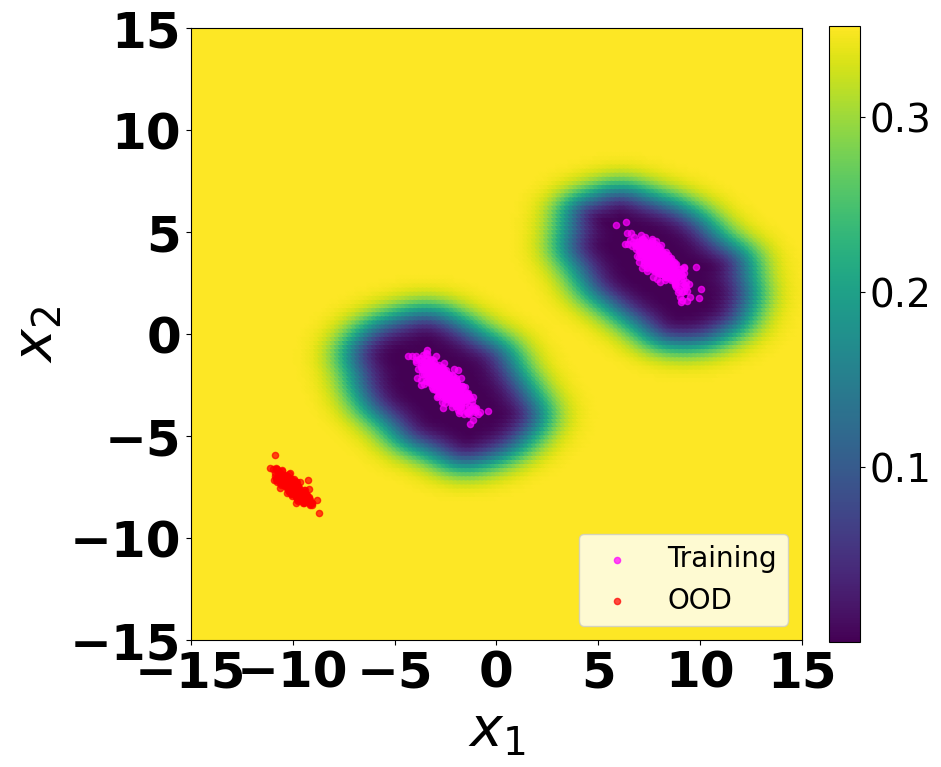

In [9]:
print('train error (RMSE):',  rmse(y_train, model_GP.predict(x_train, return_std=False)))
output, output_std = model_GP.predict(x_mesh_norm, return_std=True)
std_GP = output_std
plot_uncertainty_map(x_train, x_ood, x_mesh, output_std, 'GP', True, False)


### Uncertainty Model: Neural Network Ensemble (NNE)

- Use of Gaussian Layer that outputs - mean and aleatoric variance
- Use of Negative Log Likelihood loss (NLL)
- Ensemble to capture epistematic uncertainty

In [10]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(variance):
    def nll_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((variance)) + 
                              0.5*tf.math.divide(tf.math.square(y_true - y_pred), variance)) + 1e-6
    return nll_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [11]:
def generate_trained_NNmodel(trainX, trainY, nepochs, actfn = 'relu'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    get_gl_function - Gaussian layer outputs as function 
    """
    num_res_layers = 2
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    for _ in range(num_res_layers):
        x  = Dense(100, activation = actfn)(x)
        x1 = Dense(100, activation = actfn)(x)
        x = x1 + x
    x = Dense(10, activation = actfn)(x)   
    mu, variance = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(variance), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_gl_function = K.function(inputs=[model.input], 
                                  outputs=model.get_layer(layer_name).output)
    return get_gl_function

In [12]:
# Single run
prediction_fns, train_rmse = [], []
nmodels = 20       # Create 10 models and select some based on training error

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_NNmodel(x_train_norm, y_train_norm, nepochs = 500, actfn = 'relu')
    train_rmse.append(get_rmse(y_train_norm, my_func(x_train_norm)[0]))
    prediction_fns.append(my_func)
    
nmodels_select = 10  # select these # of models
final_NN_fns = []
for i in range(nmodels_select):
    final_NN_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])

100% |########################################################################|


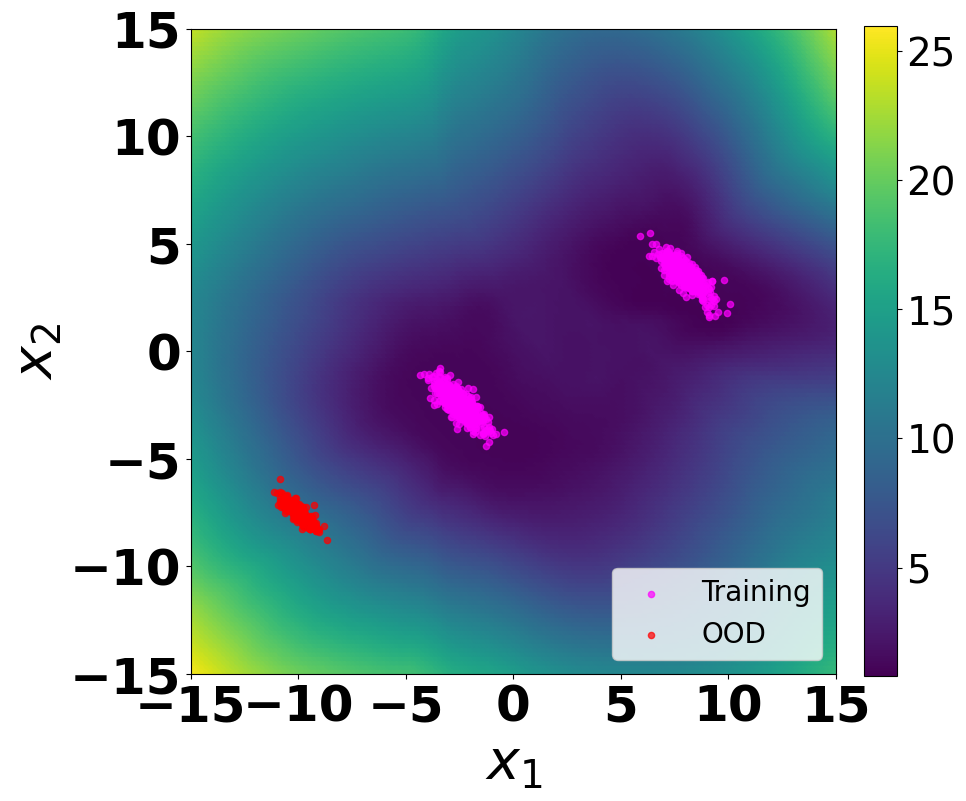

In [13]:
# Evaluate on all datasets
result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
for i in range(nmodels_select):
    result_df["NN_mu_"+str(i)] = scalerY.inverse_transform(final_NN_fns[i](x_mesh_norm)[0])
    result_df["NN_sigma_"+str(i)] = scalerY.inverse_transform(np.sqrt(final_NN_fns[i](x_mesh_norm)[1]))

result_df = get_ensemble(result_df, "NN", nmodels_select)
std_NN = result_df['NN_sigma_eff'].values
plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['NN_sigma_eff'], 
                         'NN', True, False)

## Uncertainty Model: MC Dropout (MC)

- Simple Resnet with 10% dropout probability

In [18]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'relu'):
    """
    Inputs:
    trainX  - training input of shape (samples, num of features)
    trainY  - training output of shape (samples, 1)
    nepochs - number of epochs
    actfn   - activation function
    Outputs:
    model - MC Dropout model 
    """
    num_res_layers = 2
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
#     x = Dropout(rate = 0.10)(x)
    for _ in range(num_res_layers):
        x  = Dense(100, activation = actfn)(x)
        x1 = Dense(100, activation = actfn)(x)
        x = x1 + x
        x = Dropout(rate = 0.10)(x)
    mu = Dense(1, activation = actfn)(x)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.0004)
    model = Model(feature_input, mu)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)
    return model

In [19]:
nmodels = 3 # train models and select the best out of these
all_models_MC=[]
all_rmse_train_MC = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_MC = generate_trained_MCmodel(x_train_norm, y_train_norm, 400, 'relu')
    all_rmse_train_MC[i] = get_rmse(K.get_value(model_MC(x_train_norm)), y_train_norm)
    all_models_MC.append(model_MC)
    
select_modelMC = all_models_MC[np.argmin(all_rmse_train_MC)]

100% |########################################################################|


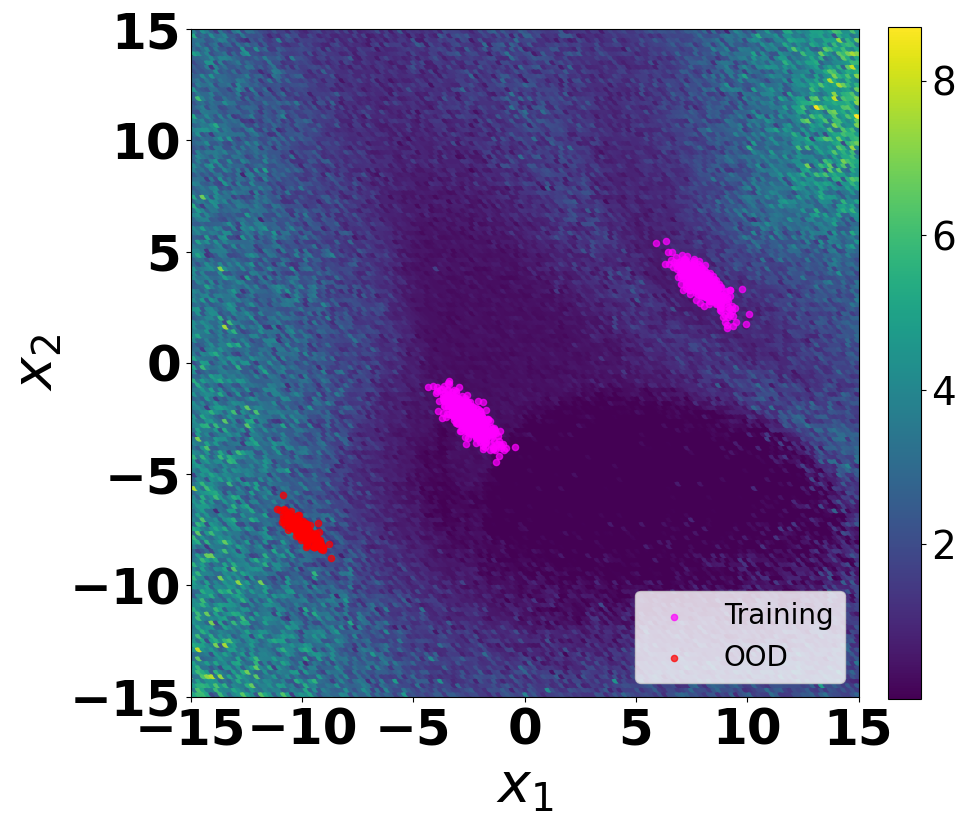

In [20]:
# Obtain the RUL prediction results for multiple runs
nensemble_size = 10
result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
for i in range(nensemble_size):
    result_df["MC_mu_"+str(i)] = scalerY.inverse_transform(K.get_value(select_modelMC(x_mesh_norm, training=True)))
    # training = True -> active dropout
    # select_modelMC -> trained MC Dropout model
    
# result_df = get_ensemble(result_df, "MC", nensemble_size)
# mu_cols = ["MC_mu_"+str(i) for i in range(nmodels_select)]
# sigma_cols = ["MC_sigma_"+str(i) for i in range(nmodels_select)]
# mu_eff = result_df[mu_cols].mean(axis=1)
# sigma_eff =  np.sqrt(np.mean(result_df[mu_cols]**2, axis = 1)- mu_eff**2)
# plot_uncertainty_map(x_train, x_ood, x_mesh, sigma_eff, 'MC', False, False)
result_df = get_ensemble(result_df, "MC", nensemble_size)
std_MC = result_df['MC_sigma_eff'].values
plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['MC_sigma_eff'], 'MC', True, False)

In [21]:
all_std = [std_GP, std_NN, std_MC]

In [22]:
def plot_uncertainty_map_scaled(x_train, x_ood, x_mesh, all_std, model_names, uniform_scaling_bool = True):
    """
    Input
    x_train, x_ood: training and OOD data
    x_mesh: input mesh spanning across the input range
    output_std: 
    """
    nmodels = np.shape(all_std)[0]
    fig, ax = plt.subplots(1,nmodels,figsize=(14, 6))
    for i, myax in zip(range(nmodels),ax.flatten()):
        std_scaled = all_std[i]
        if uniform_scaling_bool:
            sm = myax.scatter(x_mesh[:, 0], x_mesh[:, 1], rasterized = True, c = std_scaled, 
                        cmap = plt.get_cmap('viridis'), vmin=np.min(all_std), vmax=np.max(all_std))
        else:
            sm = myax.scatter(x_mesh[:, 0], x_mesh[:, 1], rasterized = True, c = std_scaled, 
                        cmap = plt.get_cmap('viridis'))
        
        plt.colorbar(sm, ax = myax)
        myax.scatter(x_train[:, 0], x_train[:, 1], color = 'magenta', s = 20, alpha = 0.7, label = 'Training')
        myax.scatter(x_ood[:, 0], x_ood[:, 1], color = 'red', s = 20, alpha = 0.7, label = 'OOD')

        myax.legend(fontsize=20, loc=4)
        myax.set_xlabel(r'$x_1$', fontsize=40, fontweight='bold')
        myax.set_ylabel(r'$x_2$', fontsize=40, fontweight='bold')
        myax.set_title(model_names[i])
#         myax.set_xticks(fontsize=36, fontweight='bold')
#         myax.set_yticks(fontsize=36, fontweight='bold')
    plt.tight_layout()

This is what we have in the paper


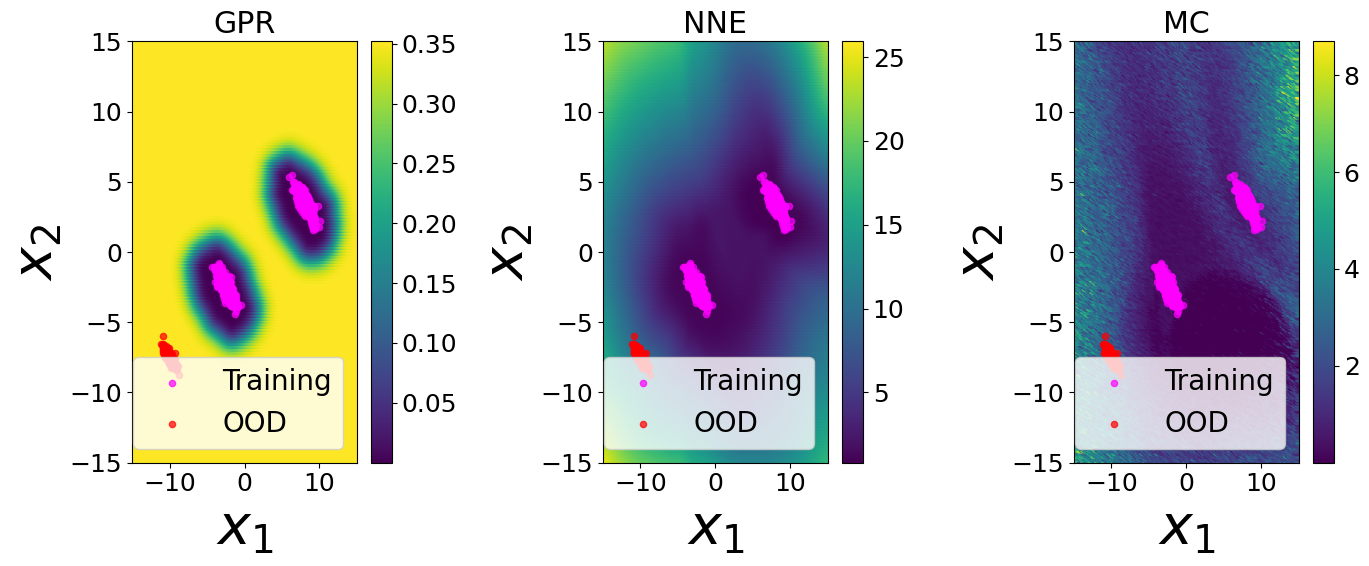

In [23]:
print('This is what we have in the paper')
plot_uncertainty_map_scaled(x_train, x_ood, x_mesh, all_std, ['GPR', 'NNE', 'MC'], False)

This is what we should have with same scaling across


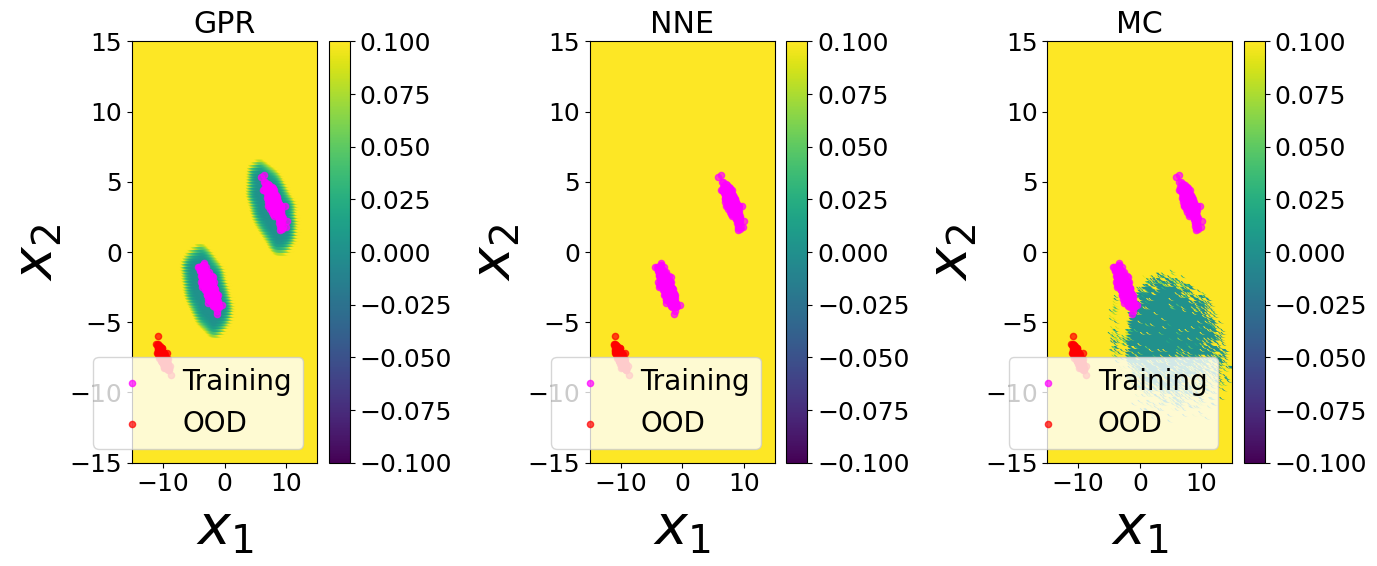

In [24]:
print('This is what we should have with same scaling across')
plot_uncertainty_map_scaled(x_train, x_ood, x_mesh, all_std, ['GPR', 'NNE', 'MC'], True)